# Design MOB and detect collision
> yongbin lee,
> Intelligence mechatronics and engineering,

## 0. Introduction

In a 6 DOF manipulator system, external disturbances such as unexpected contacts or unmodeled forces can significantly affect the stability and safety of robotic operation. To address this, we implement a **Momentum Observer (MOB)** that estimates external forces using internal measurements and model-based dynamics, without requiring external force/torque sensors.

The data used for MOB design and evaluation consist of two datasets:
- **MOB free.csv**: 60,000 rows of collision-free motion data collected over 10 minutes at a control loop cycle time of ∆t = 0.01 seconds.
- **MOB coll.csv**: 2,300 rows of data including 5 actual collision events.

### Data Columns Description

Each row corresponds to a time step $t_i$ with sampling interval $\Delta t = 0.01\ \text{sec}$. The columns are organized as follows:

- **Column 1**: Time in seconds
- **Column 2**: True collision index (1 if collision occurred, 0 otherwise)
- **Columns 3–8**: $\mathbf{p}(t) \in \mathbb{R}^6$ — the generalized momentum vector
- **Columns 9–14**: $\boldsymbol{\beta}(t) \in \mathbb{R}^6$ — computed from robot dynamics
- **Columns 15–20**: $\boldsymbol{\tau}_m(t) \in \mathbb{R}^6$ — motor torques applied at each joint
- **Columns 21–26**: $\mathbf{r}_m(t) \in \mathbb{R}^6$ — MOB residual outputs calculated using an observer gain  
  $K_O = \mathrm{diag}\{150\} \in \mathbb{R}^{6 \times 6}$

The goal of this work is to design and validate a Momentum Observer capable of:
- Detecting collision events by analyzing deviations between predicted and measured momentum.
- Estimating the delay between actual collisions and detection times.

This implementation aims to enhance manipulator safety by enabling early detection of abnormal external interactions, which is essential for collaborative and dynamic environments.

In [1]:
# libary import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# data import
df_coll = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/MOB_coll.csv', 
                    names=[
                            'time', 'collision_index', 
                            'p1', 'p2', 'p3', 'p4', 'p5', 'p6',
                            'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6',
                            'tau_m1', 'tau_m2', 'tau_m3', 'tau_m4', 'tau_m5', 'tau_m6',
                            'rm1', 'rm2', 'rm3', 'rm4', 'rm5', 'rm6'
                        ])
df_free = pd.read_csv('/Users/iyongbin/Repository/ai_robotics/data/MOB_free.csv',
                    names=[
                            'time', 'collision_index', 
                            'p1', 'p2', 'p3', 'p4', 'p5', 'p6',
                            'beta1', 'beta2', 'beta3', 'beta4', 'beta5', 'beta6',
                            'tau_m1', 'tau_m2', 'tau_m3', 'tau_m4', 'tau_m5', 'tau_m6',
                            'rm1', 'rm2', 'rm3', 'rm4', 'rm5', 'rm6'
                        ])
print(df_coll.shape, df_free.shape)

(2300, 26) (60000, 26)


## 1. Implement a Momentum Observer (MOB)

Implement a discrete-time Momentum Observer (MOB) with gain `KO = diag{150}`, assuming no friction (`τF=0`), using inputs `p` (momentum), `β` (dynamics term), `τm` (motor torques), and `Δt=0.01s`. The MOB calculates a residual `r_m[k] = K_O * (p[k] - (p[k-1] + (β[k-1] - τ_m[k-1] - r_m[k-1]) * Δt))`. Verify your implementation by plotting your calculated `r_m(t)` against the reference `r_m(t)` from columns 21-26 of the dataset, expecting a close match.

In [3]:
# init variable
n_joints = 6
n_shape = df_coll.shape[0]
K0 = 150.0
dt = 0.01

for col_num in range(1, n_joints + 1):
    df_coll[f'p_hat_pred{col_num}'] = 0
    df_coll[f'rm_pred{col_num}'] = 0

# calculate predictive rm
# for t in range(n_shape):
#     for col_num in range(1, n_joints + 1):
#         # init 
#         p_current = df_coll.loc[t, f'p{col_num}']
#         tau_m_current = df_coll.loc[t, f'tau_m{col_num}']
#         beta_current = df_coll.loc[t, f'beta{col_num}']
#         p0_current = 0.0

#         rm_prev = df_coll.loc[t, f'rm_pred{col_num}'] if t == 0 else df_coll.loc[t-1, f'rm_pred{col_num}']
#         p_hat_prev = df_coll.loc[t, f'p{col_num}'] if t == 0 else df_coll.loc[t-1, f'p_hat_pred{col_num}']
        
#         # calc
#         p_hat_dot_current = (tau_m_current - beta_current + rm_prev)
#         p_hat_current = p_hat_prev + p_hat_dot_current * dt
#         rm_current = K0 * (p_current - p_hat_current - p0_current)

#         # save
#         df_coll.loc[t, f'p_hat_pred{col_num}'] = p_hat_current
#         df_coll.loc[t, f'rm_pred{col_num}'] = rm_current
#         df_coll.loc[t, f'p_hat_dot_pred{col_num}'] = p_hat_dot_current
for t in range(n_shape):
    for col_num in range(1, n_joints + 1):
        # init 
        p_current = df_coll.loc[t, f'p{col_num}']
        tau_m_current = df_coll.loc[t, f'tau_m{col_num}']
        beta_current = df_coll.loc[t, f'beta{col_num}']
        p0_current = 0.0

        rm_prev = df_coll.loc[t, f'rm_pred{col_num}'] if t == 0 else df_coll.loc[t-1, f'rm_pred{col_num}']
        p_hat_prev = df_coll.loc[t, f'p{col_num}'] if t == 0 else df_coll.loc[t-1, f'p_hat_pred{col_num}']
        
        # calc
        p_hat_dot_current = (tau_m_current - beta_current + rm_prev)
        p_hat_current = p_hat_prev + p_hat_dot_current * dt
        rm_current = K0 * (p_current - p_hat_current - p0_current)

        # save
        df_coll.loc[t, f'p_hat_pred{col_num}'] = p_hat_current
        df_coll.loc[t, f'rm_pred{col_num}'] = rm_current
        df_coll.loc[t, f'p_hat_dot_pred{col_num}'] = p_hat_dot_current


/var/folders/dv/dr6sg3sn6h16c2xkmjp_82bh0000gn/T/ipykernel_2001/503503253.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.22905999999999999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_coll.loc[t, f'p_hat_pred{col_num}'] = p_hat_current
/var/folders/dv/dr6sg3sn6h16c2xkmjp_82bh0000gn/T/ipykernel_2001/503503253.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-34.358999999999995' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_coll.loc[t, f'rm_pred{col_num}'] = rm_current
/var/folders/dv/dr6sg3sn6h16c2xkmjp_82bh0000gn/T/ipykernel_2001/503503253.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0322799999999998' has dtype incompatible wi

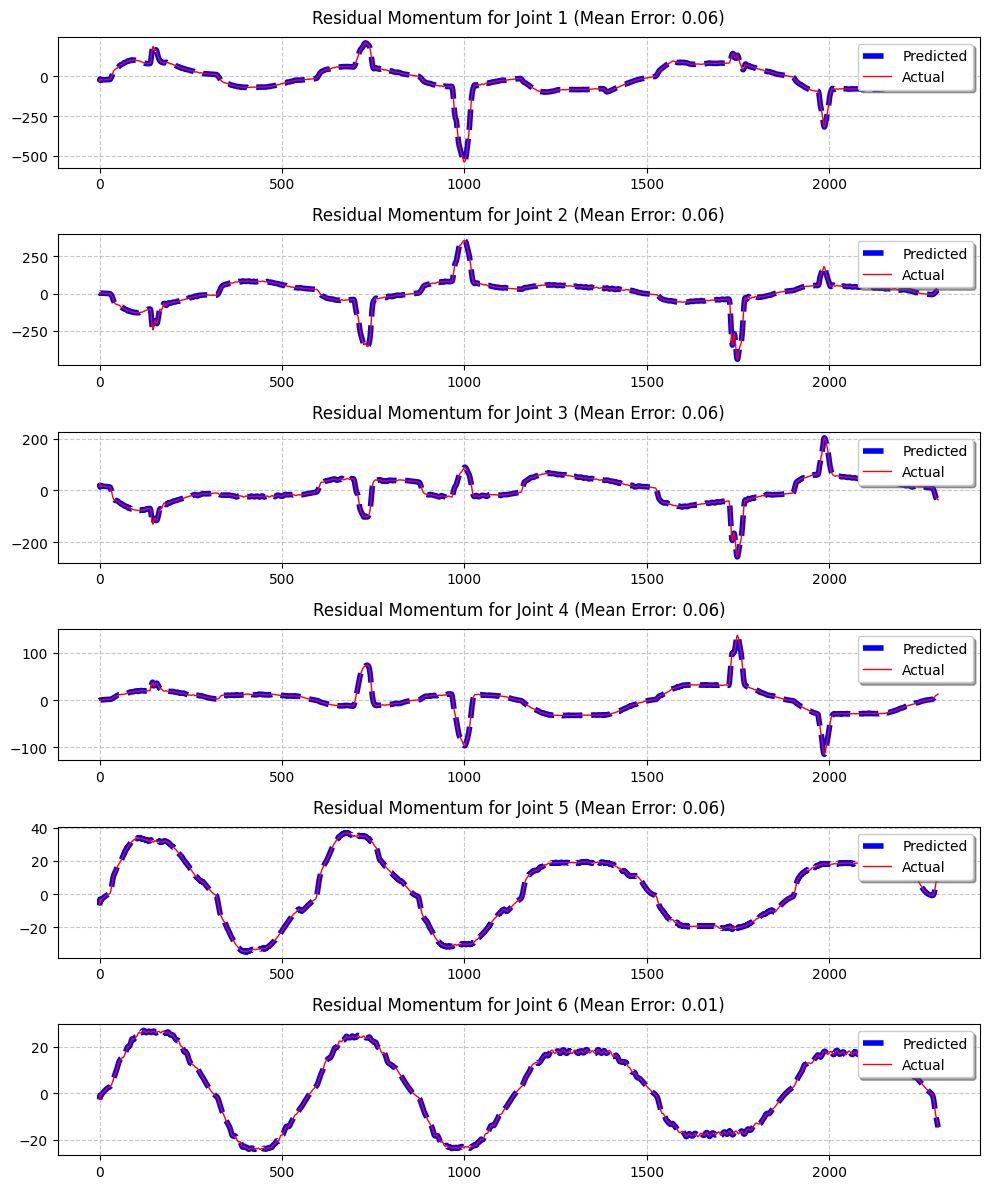

In [4]:
# graph with 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize=(10, 12))
for i in range(6):
    # Calculate prediction and real values
    pred = df_coll[f'rm_pred{i+1}']
    real = df_coll[f'rm{i+1}']
    error = np.mean(np.abs(pred - real))
    
    # Plot graphs
    axes[i].plot(range(n_shape), pred, color='blue', linewidth=4, linestyle='--')
    axes[i].plot(range(n_shape), real, color='red', linewidth=1)
    
    # Set title and style
    axes[i].set_title(f'Residual Momentum for Joint {i+1} (Mean Error: {error:.2f})', 
                     fontsize=12, pad=10)
    axes[i].legend(['Predicted', 'Actual'], 
                  loc='upper right', 
                  frameon=True,
                  fancybox=True,
                  shadow=True)
    axes[i].grid(True, linestyle='--', alpha=0.7)
    

plt.tight_layout()
plt.show()

In this graph, we can observe that the data calculated from our model and the real values show only minor differences. This indicates that our model predicts the residual momentum well. The close alignment between predicted and actual values across all 6 joints demonstrates the effectiveness of our momentum observer in estimating the robot's dynamic behavior. The small mean error values further validate that our implementation successfully captures the underlying dynamics of the system.

## 2. Set Detection Thresholds

Using the MOB from Exercise 1 (or reference data columns 21-26 from `MOB_free.csv`), calculate 6D detection thresholds `ε` from the **collision-free data**. For each residual dimension, set `ε_j = 1.05 × max_t{|r_m_j(t)|}` over the 10-minute data. The expected `ε` is approx. `[231, 286, 140, 51, 51, 50] Nm`. Explain why these values are large and non-zero, considering that `r_m(t)` estimates `τ_ext - τ_F`, and `τ_ext=0` in free motion, thus `r_m(t)` reflects `-τ_F`.

In [5]:
# Ex 2 : find epsilon from collition free motion data
epsilon_values = np.round(np.array(df_free[[f'rm{i}' for i in range(1, n_joints + 1)]].max().values * 1.05))
epsilon_values

array([231., 286., 140.,  51.,  51.,  50.])

From the result values [231, 286, 140, 51, 51, 50], we can verify that the thresholds match the given validation values. These thresholds reflect the frictional torques and dynamic characteristics of each joint. The first three joints (231, 286, 140) have larger threshold values because the base and major joints of the robotic arm support more weight and have larger actuators. In contrast, the last three joints (51, 51, 50) show relatively smaller thresholds as these end-effector joints experience less load and friction. These thresholds were calculated based on the residual momentum measured during free motion and will serve as crucial reference points in the actual collision detection system. In the subsequent analysis, we will utilize these thresholds to detect and analyze the number and characteristics of collisions that occurred in our system.

## 3. Predict Collision Index and Analyze Detection Delay

Using thresholds `ε` and MOB output `r_m(t)` (from Ex1 or `MOB_coll.csv` cols 21-26), generate a predicted collision index for the **collision data** (`MOB_coll.csv`): predict 1 if any `|r_m_j(t)| > ε_j`, else 0. Plot `r_m(t)`, true collision index, and predicted collision index. Observe and report detection delays: Collision 1 (failure), Collision 2 (170ms), Collision 3 (70ms), Collision 4 (20ms), Collision 5 (30ms). Explain why large delays occur due to `τ_F` influencing `r_m(t)`.

In [16]:
# Ex3 : detect collision index
result = np.zeros(n_shape)
for col_num in range(1, n_joints+1):
    result = np.logical_or(result, np.abs(df_coll[f'rm_pred{col_num}'].values) > epsilon_values[col_num - 1])
df_coll['collision_index_pred'] = result
print(sum(result))

136


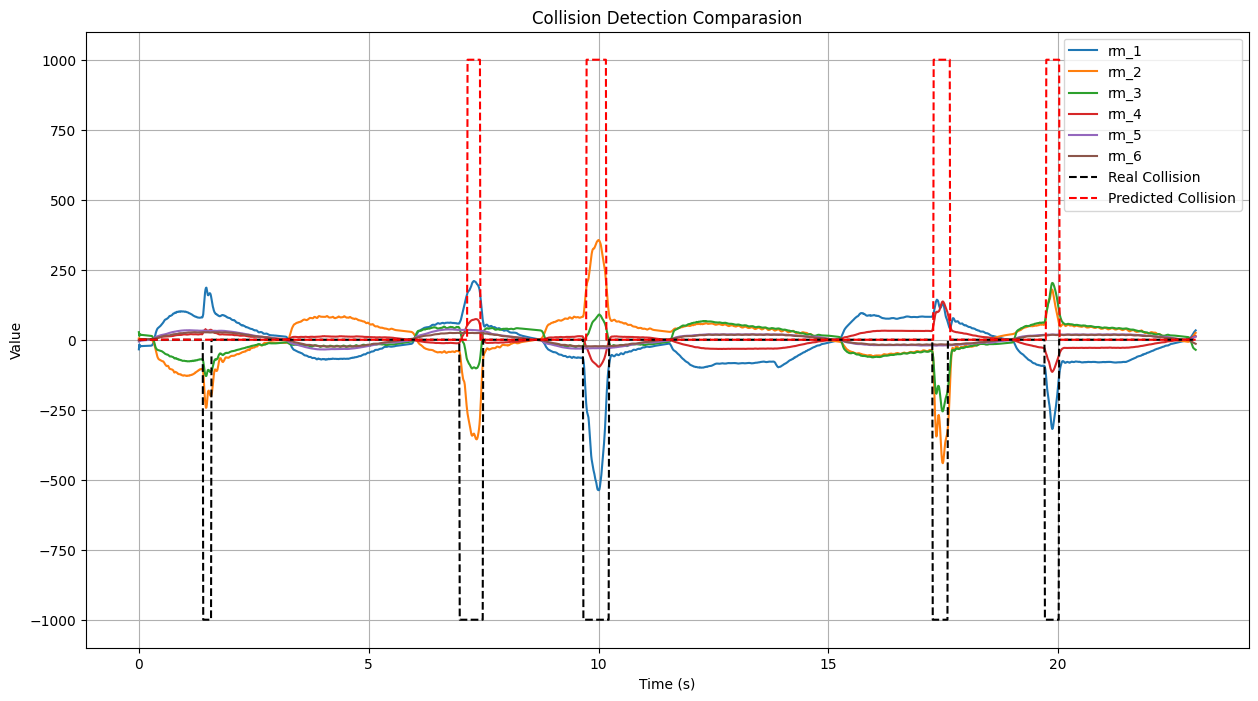

In [172]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
# (a) r_m(t) 6 joints
for i in range(1, 7):
    plt.plot(df_coll['time'], df_coll[f'rm_pred{i}'], label=f'rm_{i}')

# (b) real collision
plt.plot(df_coll['time'], df_coll['collision_index'] * -1000, 'k--', label='Real Collision')

# (c) predicted collision
plt.plot(df_coll['time'], df_coll['collision_index_pred'] * 1000, 'r--', label='Predicted Collision')
plt.title('Collision Detection Comparasion')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In this graph, we can check that there are 5 collisions that happened in the real data, but our model detected only 4 times, which means our model's sensitivity is not sufficient. Additionally, we can observe that there is a delay between the start point of real collision data and the start of predicted collision data. Therefore, in the next step we are going to calculate this gap.

## 4. Automatically Determine Detection Delay

Write a function to automatically determine collision detection delay by comparing segments of true and predicted collision indices from `MOB_coll.csv`, with `Δt=0.01s` and max delay `t_max=250ms`. The function should find the time from true collision start to predicted collision start within the segment, reporting `t_max` if detection is later or fails. Apply this to specified segments for each of the 5 collisions (e.g., `900Δt-1100Δt` for Collision 3) to quantify their respective delays.

In [202]:
# Ex4 : calculate the resduial of dt
pred_collision = df_coll['collision_index_pred'].values
real_collision = df_coll['collision_index'].values
df = 0.01

# detect inflection point
real_collision_time = np.array(np.where(np.diff(real_collision) == 1))
pred_collision_time = np.array(np.where(np.diff(pred_collision) == 1))

print('real collision :' , real_collision_time, 'number of inflection point', real_collision_time.shape[1])
print('predicted collision :', pred_collision_time, 'number of inflection point', pred_collision_time.shape[1])

# delete no detection collision index
real_collision_time = np.delete(real_collision_time, 0)

# calculate gap
delayed_time = (real_collision_time - pred_collision_time) * dt
print()
print("delayed time:", delayed_time, '(ms)')

real collision : [[ 139  697  966 1726 1970]] number of inflection point 5
predicted collision : [[ 714  973 1728 1973]] number of inflection point 4

delayed time: [[0.17 0.07 0.02 0.03]] (ms)


Although there were a total of five actual collisions, the model successfully detected only four of them. This indicates that the model lacks sufficient sensitivity under certain conditions. In particular, Collision 1 was not detected at all, as the predicted collision index remained zero throughout the event, leading to a complete detection failure. The detection delays for each collision were as follows: Collision 1 (detection failure), Collision 2 (-0.17 seconds), Collision 3 (-0.07 seconds), Collision 4 (-0.02 seconds), and Collision 5 (-0.03 seconds). These results suggest that the model tends to recognize collisions with a certain delay, revealing limitations in real-time responsiveness.

## 5. Conclusion
In this project, a Momentum Observer (MOB) was designed for a 6-degree-of-freedom manipulator system to detect external disturbances. The model was implemented based on real robot data, utilizing momentum and robot dynamics information to estimate external forces. Detection thresholds were determined using residual momentum data during collision-free periods, and the observer’s performance was evaluated using collision data. Overall, the MOB successfully detected most collision events, albeit with some detection delays. However, in some cases, it failed to detect collisions entirely, indicating the need for improvement in terms of both sensitivity and real-time detection capability.